# Cancer Inhibitors

## About the project

Cancer is a multi gene disease, and the modern medical therapies focus on protein kinase which are play important role the development of cancer.

Each protein kinase regulate each different pathway. These kinase regulate the cell differentiation, cell proliferation.
There are three type of cancer gene:
* Oncogene, where the over representation or over activation of the gene lead to cancer.
* Tumorsuppressor, where the inactivation of the gene lead to cancer.
* Context-dependent, where development of the cancer depend on tissue or other genes.

As cancer is a multi gene disease, several gene malfunction needed to develop the disease.

The new therapies inhibits these kinase to block their functions. In this project we try to predict potential inhibitors.

## About the dataset

The protein kinase list:

* Cyclin-dependent kinase 2: cdk2
* Epidermal growth factor receptor erbB1: egfr_erbB1
* Glycogen synthase kinase-3 beta: gsk3b
* Hepatocyte growth factor receptor: hgfr
* MAP kinase p38 alpha: mapkp38a
* Tyrosine-protein kinase LCK: tpk_lck
* Tyrosine-protein kinase SRC: tpk_src
* Vascular endothelial growth factor receptor 2: vegfr2

For each protein kinase, several thousand inhibitors are collected from chembl database, in which molecules with IC50 lower than 10 uM are usually considered as inhibitors, otherwise non-inhibitors.

### Challenge
Based on those labeled molecules, build your model, and try to make the right prediction.

Additionally, more than 70,000 small molecules are generated from pubchem database. And you can screen these molecules to find out potential inhibitors. P.S. the majority of these molecules are non-inhibitors.

### DataSets(hdf5 version)
There are 8 protein kinase files and 1 pubchem negative samples file.
Taking "cdk2.h5" as an example:

    import h5py
    from scipy import sparse
    hf = h5py.File("../input/cdk2.h5", "r")
    ids = hf["chembl_id"].value # the name of each molecules
    ap = sparse.csr_matrix((hf["ap"]["data"], hf["ap"]["indices"], hf["ap"]["indptr"]), shape=[len(hf["ap"]["indptr"]) - 1, 2039])
    mg = sparse.csr_matrix((hf["mg"]["data"], hf["mg"]["indices"], hf["mg"]["indptr"]), shape=[len(hf["mg"]["indptr"]) - 1, 2039])
    tt = sparse.csr_matrix((hf["tt"]["data"], hf["tt"]["indices"], hf["tt"]["indptr"]), shape=[len(hf["tt"]["indptr"]) - 1, 2039])
    features = sparse.hstack([ap, mg, tt]).toarray() # the samples' features, each row is a sample, and each sample has 3*2039 features
    labels = hf["label"].value # the label of each molecule

### Q&A
Q. What does the "chembl_id" encode for in the PubChem negative samples?
A. Pubchem CID.

Q. Difference between h5 and csv data?
A. The csv format and h5 are different versions. You can use either of them. The h5 version: In my sample code (pkinput.py and pkrandom_forest.py, I use a combination of three sets of fingerprints(ap, mg, and tt for short), and each set contains 2039 fingerprints, the total number of fingerprints(columns) are 6117. The csv version: The first column is the label, the rest columns are feature. Only the set of Mogan(mg for short) fingerprints is used as features, and the number is 8192.

Q. How the features(fingerprints) are generated? How does the features(fingerprints) selected?
A. (Take csv version as an example)The features are a subset of fingerprints. The fingerprints' ID is just a integer(e.g. 10552354, 10552386, 10552674) and meaningless, thus not showed. That's why there are no column names in csv files. The csv file contains label and features. Expect the first column is label, the left columns are the feature data. The feature data is a matrix with shape=(N, 8192), where N is the number of molecules, and 8192 is the number of fingerprints. The fingerprints are selected if it is 'frequent' enough. The 'rare' fingerprints: the fingerprints only appear in <5%(the ratio could be adjusted) of all the molecules in the dataset.

Q. What does 'ap', 'mg', and 'tt' mean in h5 files?
A. 'ap', 'mg', 'tt' are short for 'Atom Pairs', 'Morgan Fingerprints (Circular Fingerprints)', 'Topological Torsions'. They are three different sets of molecular fingerprints calculated by RDKIT. For more information: http://www.rdkit.org/docs/GettingStartedInPython.html#topological-fingerprints

Q. ID of the molecules in csv version?
A. Unfortunately it's missed and could not be recovered. If you need the molecules, you can use the ID from h5 files, and retrieve their structure in SMILES format by chembl_id from ChEMBL database(or in sdf format by pubchem cid from Pubchem database ), and finally, use RDKit to compute any fingerprints needed.

### Reference
* http://onlinelibrary.wiley.com/doi/10.3322/caac.21338/full
* https://www.ebi.ac.uk/chembl/
* https://pubchem.ncbi.nlm.nih.gov/
* http://www.rdkit.org/
* http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints

In [1]:
import warnings

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

warnings.filterwarnings('ignore')
print("Modules imported!")
print("Collecting Data...")

Modules imported!


In [2]:
from sklearn.linear_model import OrthogonalMatchingPursuit, LogisticRegression, ElasticNetCV, HuberRegressor, Ridge,Lasso, LassoCV, Lars, BayesianRidge, SGDClassifier, RidgeClassifier, LarsCV,
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.metrics import r2_score

print("sklearn modules imported")

sklearn modules imported


In [3]:
from scipy.sparse import coo_matrix

print("sklearn data normalizing modules imported")

sklearn data normalizing modules imported


In [190]:
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

print("modules for optimizing")

modules for optimizing


In [191]:
import matplotlib.pyplot as plt

print("matplotlib modules imported")

matplotlib modules imported


In [5]:
from sklearn import svm
from sklearn import metrics
from tqdm import tqdm

In [6]:
files = {
    "cdk2": "input/cdk2.h5",
    "egfr": "input/egfr_erbB1.h5",
    "gsk3b": "input/gsk3b.h5",
    "hgfr": "input/hgfr.h5",
    "map_k_p38a": "input/map_k_p38a.h5",
    "tpk_lck": "input/tpk_lck.h5",
    "vegfr2": "input/vegfr2.h5",
}

In [12]:
def pre_process_data(filepath):
    hf = h5py.File(filepath, "r")
    ids = hf["chembl_id"]
    ap = sparse.csr_matrix((hf["ap"]["data"], hf["ap"]["indices"], hf["ap"]["indptr"]),
                           shape=[len(hf["ap"]["indptr"]) - 1, 2039])
    mg = sparse.csr_matrix((hf["mg"]["data"], hf["mg"]["indices"], hf["mg"]["indptr"]),
                           shape=[len(hf["mg"]["indptr"]) - 1, 2039])
    tt = sparse.csr_matrix((hf["tt"]["data"], hf["tt"]["indices"], hf["tt"]["indptr"]),
                           shape=[len(hf["tt"]["indptr"]) - 1, 2039])
    features = sparse.hstack(
        [ap, mg, tt]).toarray()  # the samples' features, each row is a sample, and each sample has 3*2039 features
    labels = hf["label"][:]  # the label of each molecule
    return features, labels, ids

In [37]:
features, labels, ids = pre_process_data(files["cdk2"])

In [38]:
labels

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [39]:

class DataNormalize():
    def __init__(self, features):
        self.plays = coo_matrix(features)
        self.similarity = self.bm25().todense()

    def bm25_weight(self, K1=1.2, B=0.8):
        """ Weighs each row of the matrix data by BM25 weighting """
        # calculate idf per term
        data = self.plays
        N = float(data.shape[0])
        idf = np.log(N / (1 + np.bincount(data.col)))

        # calculate length_norm per document
        row_sums = np.squeeze(np.asarray(data.sum(1)))
        average_length = row_sums.sum() / N
        length_norm = (1.0 - B) + B * row_sums / average_length

        # weight matrix rows by bm25
        ret = coo_matrix(data)
        ret.data = ret.data * (K1 + 1.0) / (K1 * length_norm[ret.row] + ret.data) * idf[ret.col]
        return ret

    def bm25(self):
        self.plays = self.bm25_weight()
        return self.plays.dot(self.plays.T)

    def svd(self):
        self.U, self.sigma, self.Vt = np.linalg.svd(self.similarity[:, :200], full_matrices=False)
        self.sigm = np.diag(self.sigma)
        return self.U, self.sigma, self.Vt

In [40]:
normalize_dat = DataNormalize(features)
similarity = normalize_dat.similarity
U, sigma, Vt = normalize_dat.svd()
similarity

matrix([[1081.06364495,   90.18583029,   42.32094192, ...,   80.48898524,
           78.47186794,   82.09391297],
        [  90.18583029, 1008.21046951,  101.51321267, ...,  125.45888792,
          103.52277725,  146.84308866],
        [  42.32094192,  101.51321267, 1457.0755857 , ...,  137.73886646,
          458.1301387 ,  275.72155783],
        ...,
        [  80.48898524,  125.45888792,  137.73886646, ..., 3472.66003308,
          154.32427957,  182.3394268 ],
        [  78.47186794,  103.52277725,  458.1301387 , ...,  154.32427957,
         3038.38008702,  504.99802758],
        [  82.09391297,  146.84308866,  275.72155783, ...,  182.3394268 ,
          504.99802758, 1790.79614242]])

In [41]:
print(U.shape, sigma.shape, Vt.shape)

(1890, 200) (200,) (200, 200)


In [211]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}

X = U
Y = labels

base_lasso = Lasso(alpha=0.05)
base_sgd = SGDClassifier()
base_ridge = RidgeClassifier()
base_log = LogisticRegression()

names = [
    'ElasticNet',
    'SVC',
    'kSVC',
    'KNN',
    'DecisionTree',
    'RandomForestClassifier',
    'GridSearchCV',
    'HuberRegressor',
    'Ridge',
    'Lasso',
    'LassoCV',
    'Lars',
    'LarsCV',
    'BayesianRidge',
    'SGDClassifier',
    'RidgeClassifier',
    'LogisticRegression',
    'OrthogonalMatchingPursuit',
]

classifiers = [
    ElasticNetCV(cv=10, random_state=0),
    SVC(),
    SVC(kernel='rbf', random_state=0),
    KNeighborsClassifier(n_neighbors=1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    GridSearchCV(SVC(), param_grid, refit=True, verbose=1),
    HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100, epsilon=2.95),
    Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True),
    base_lasso,
    LassoCV(),
    Lars(n_nonzero_coefs=10),
    LarsCV(),
    BayesianRidge(),
    base_sgd,
    base_ridge,
    base_log,
    OrthogonalMatchingPursuit(),
]

In [48]:
class Classifier():
    def __init__(self, name, classifier):
        self.name = name
        self.classifier = classifier

    def rmsle(self):
        return np.sqrt(np.mean(np.power(np.log1p(self.y_pred) - np.log1p(self.Y), 2)))

    def percenterror(self):
        return np.round(np.mean(np.abs(self.y_pred - self.Y)) / np.mean(self.Y) * 100, 1)

    def predict(self, X, Y):
        res = self.classifier.fit(X, Y)
        self.y_pred = res.predict(X)
        self.Y = Y
        return self.y_pred

    def cm(self):
        matrix = confusion_matrix(self.Y, np.round(self.y_pred))
        return matrix

    def cr(self):
        report = classification_report(Y, np.round(self.y_pred))
        return report

    def acc(self):
        logreg_accuracy = round(accuracy_score(Y, np.round(self.y_pred)) * 100, 2)
        return logreg_accuracy


In [253]:
class Multiple_prediction():

    def __init__(self, names, classifiers, X, Y):
        self.names = names
        self.classifiers = classifiers
        self.X = X
        self.Y = Y

    def run_predictions(self):
        temp = zip(self.names, self.classifiers)

        self.results = {}

        for name, clf in temp:
            print(name)
            regr = Classifier(name, clf)
            y_pred = regr.predict(self.X , self.Y)
            report = regr.cr()
            matrix = regr.cm()
            logreg_accuracy = regr.acc()

            # Save it to results
            self.results[name] = {
                "report": report,
                "matrix": matrix,
                "logreg_accuracy": logreg_accuracy,
                "y_pred": y_pred,
            }
        return self.results

    def sep_results(self, treshold=90):
        self.below_res = {}
        self.above_res = {}
        for name, feature in self.results.items():
            if feature["logreg_accuracy"] <= treshold:
                self.below_res[name] = feature
            else:
                self.above_res[name] = feature
        return self.above_res, self.below_res




In [256]:
class Multiple_plots():
    def __init__(self,result,name,Y):
        self.name = name
        self.result = result
        self.Y = Y

    def roc_plot_from_res(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        for name, feature in self.result.items():
            y_pred = feature["y_pred"]
            RocCurveDisplay.from_predictions(self.Y, y_pred, ax=ax,
                                             name='{} auc: {}'.format(name, feature["logreg_accuracy"]))
        ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)
        ax.set_title("Classifier: " + self.name)
        plt.show()
        return fig, ax

    def matrix_plot_from_res(self):

        row = 0
        cols = 0

        modulos = []
        dividers = []
        for i in reversed(range(2,6)):
            modulo = len(self.result) % i
            modulos.append(modulo)
            dividers.append(i)
            if modulo == 0:
                row = i
                cols = int(len(self.result) / i)
                break

        if not row:
            modulo = min(modulos)
            divider = dividers[modulos.index(modulo)]
            row = divider + 1
            cols = int(len(self.result) / divider)

        plt.figure(figsize=(15, 15))
        plt.subplots_adjust(hspace=0.5)
        plt.suptitle(self.name, fontsize=18, y=0.95)
        # fig, axs = plt.subplots(ncols=cols,nrows=row)
        count = 0
        for name, feature in self.result.items():
            ax = plt.subplot(row, cols, count + 1)
            ax.legend = name
            ax.set_title("Classifier: " + name)
            sns.heatmap(pd.DataFrame(feature["matrix"]), annot=True, cmap='Reds', ax=ax, fmt='g')
            count += 1
        plt.show()
        return

In [184]:
multiple_preds = Multiple_prediction(names,classifiers, X, Y)

In [185]:
results = multiple_preds.run_predictions()

ElasticNet
SVC
kSVC
KNN
DecisionTree
RandomForestClassifier
GridSearchCV
Fitting 5 folds for each of 9 candidates, totalling 45 fits
HuberRegressor
Ridge
Lasso
LassoCV
Lars
LarsCV
BayesianRidge
SGDClassifier
RidgeClassifier
LogisticRegression
OrthogonalMatchingPursuit


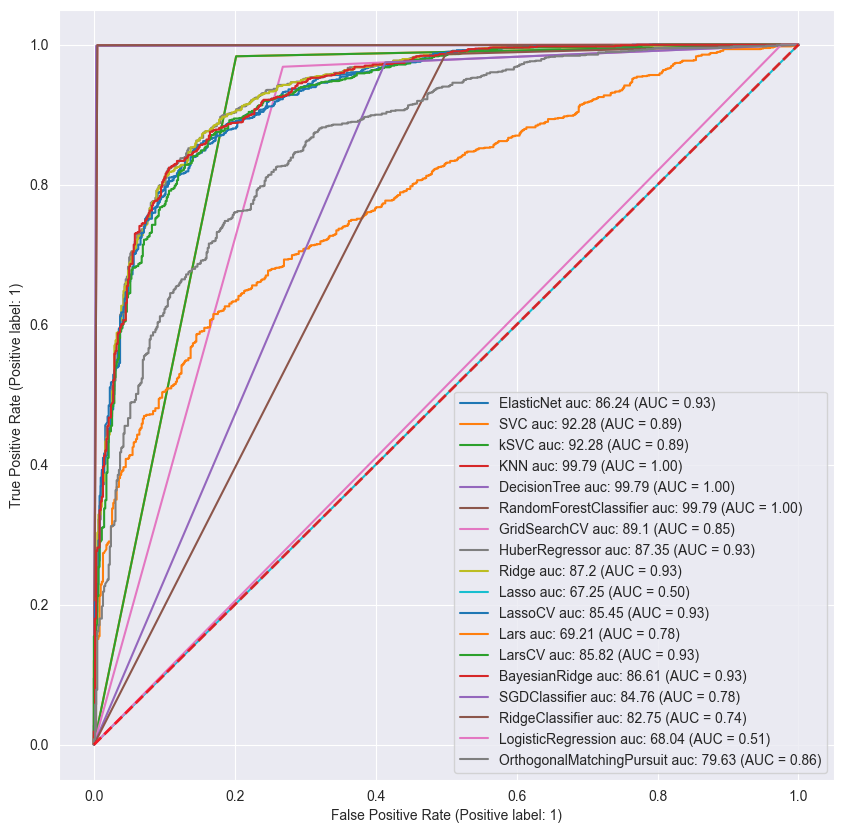

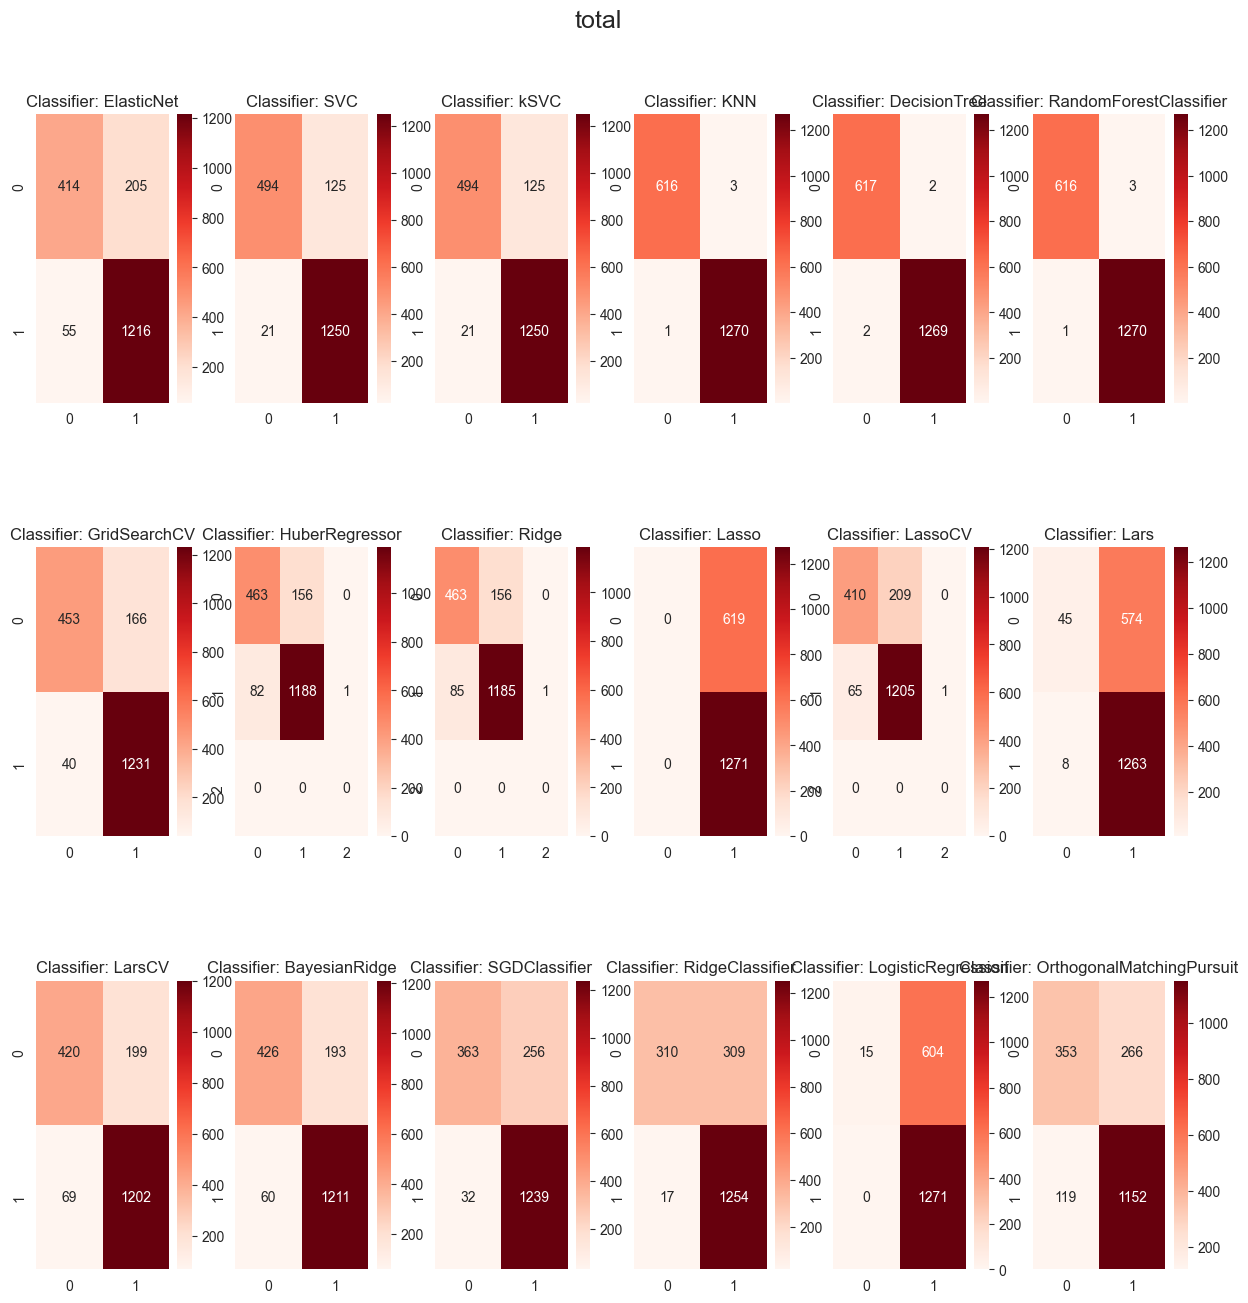

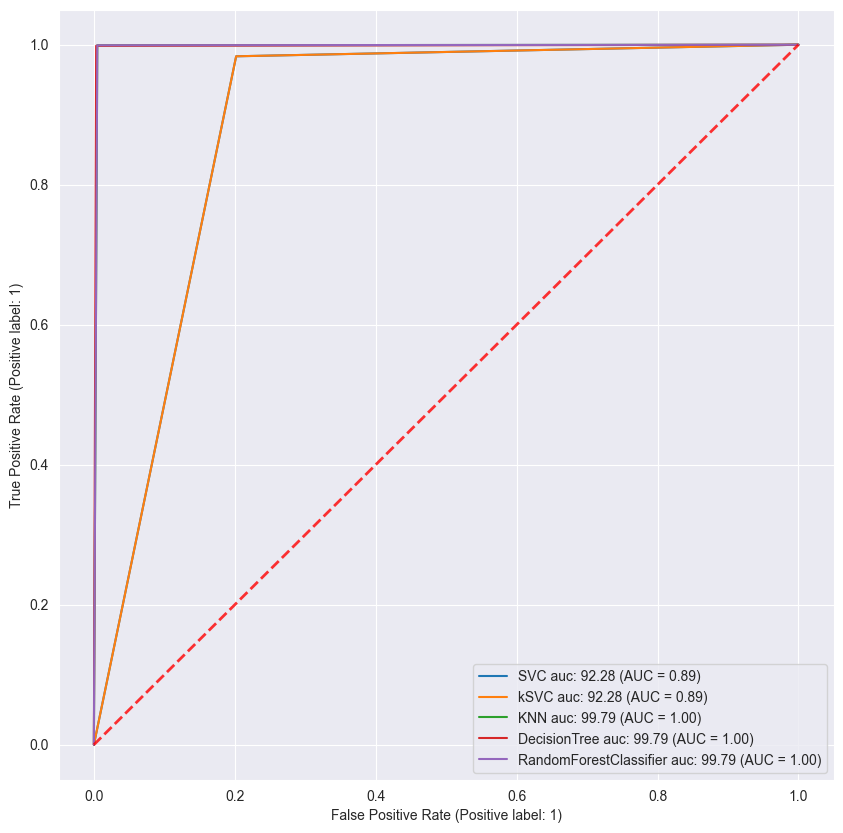

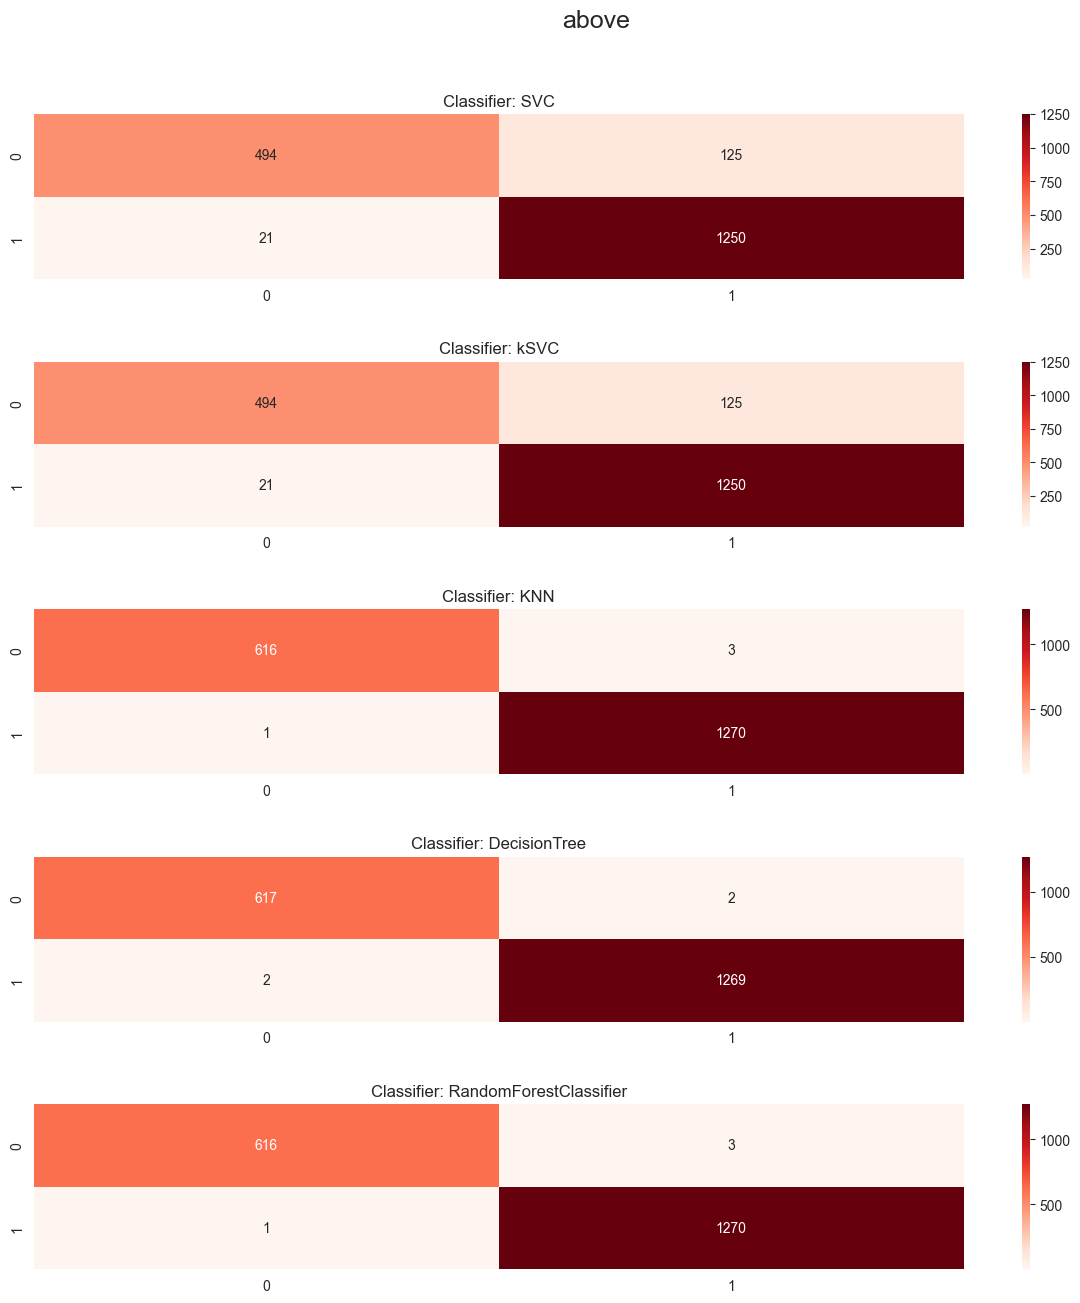

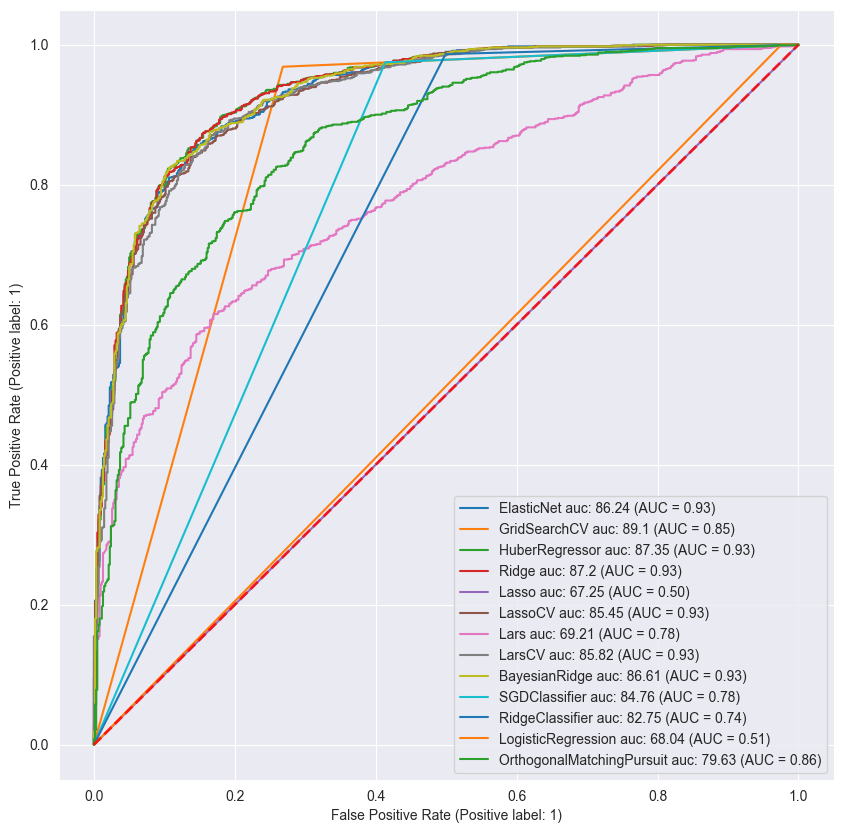

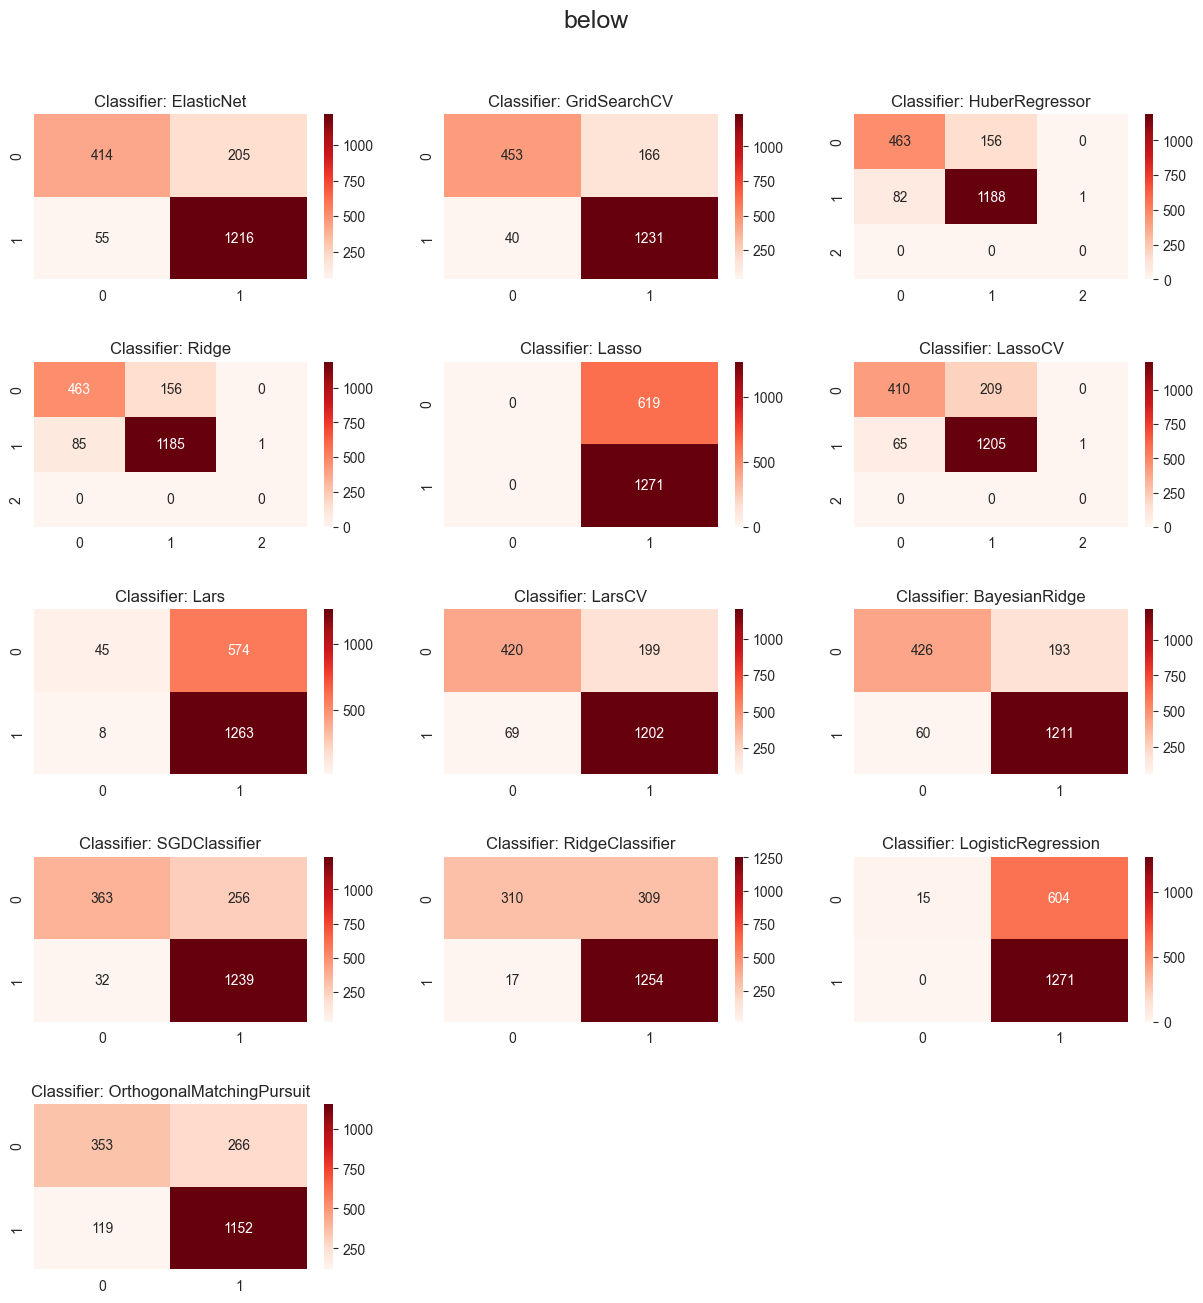

In [186]:
above_res, below_res = multiple_preds.sep_results()
res_dict = {
    "total":results,
    "above":above_res,
    "below":below_res,
}
for name,res in res_dict.items():
    multiple_plt = Multiple_plots(res,name,Y)
    multiple_plt.roc_plot_from_res()
    multiple_plt.matrix_plot_from_res()

In [194]:
class Optimizer():
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y

    def grid_search_optimizer(self, grid_search):
        grid_result = grid_search.fit(self.X, self.Y)

        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
        return grid_result.best_params_

    def logistic_regression_hyper(self):
        model = LogisticRegression()
        solvers = ['newton-cg', 'lbfgs', 'liblinear']
        penalty = ['l2']
        c_values = [100, 10, 1.0, 0.1, 0.01]
        # define grid search
        grid = dict(solver=solvers, penalty=penalty, C=c_values)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

        self.logistic_params = self.grid_search_optimizer(grid_search)

        self.log_model = LogisticRegression(C=self.logistic_params["C"], penalty=self.logistic_params["penalty"],solver=self.logistic_params["solver"])

        return self.log_model,self.logistic_params

    def ridge_classifier_hyper(self):
        # define models and parameters
        model = RidgeClassifier()
        alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        # define grid search
        grid = dict(alpha=alpha)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

        self.ridge_params = self.grid_search_optimizer(grid_search)

        self.ridge_model = RidgeClassifier(self.ridge_params["alpha"])

        return self.ridge_model, self.ridge_params

    def sgd_classifier_hyper(self):
        model = SGDClassifier()
        # define models and parameters
        grid = {
            # 'alpha': [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1], # learning rate
            'alpha': np.linspace(1e-06, 1e-04, 10),  # learning rate
            # 'n_iter': [1000], # number of epochs
            'loss': ['log_loss', 'hinge', 'squared_hinge', 'log'],  # logistic regression,
            'penalty': ['l1', 'l2', 'elasticnet'],
            'n_jobs': [-1]
        }
        # paramGrid = ParameterGrid(grid)

        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy', error_score=0)

        self.sgd_params = self.grid_search_optimizer(grid_search)

        self.sgd_model = SGDClassifier(alpha=self.sgd_params["alpha"],
                                       n_jobs=self.sgd_params["n_jobs"], loss=self.sgd_params["loss"], penalty=self.sgd_params["penalty"])

        return self.sgd_model, self.sgd_params

    def lasso_hyper(self):
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        lasso_alphas = np.linspace(0, 0.001, 100)
        lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
        lasso.fit(self.X, self.Y)
        self.alpha = lasso.alpha_
        self.lasso_model = Lasso(self.alpha)
        return self.lasso_model, self.alpha


In [195]:
optimizer = Optimizer(X,Y)
log_model, logistic_params = optimizer.logistic_regression_hyper()

Best: 0.832628 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832628 (0.028541) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832628 (0.028541) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.832628 (0.028541) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.821869 (0.024979) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.822046 (0.024910) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.822046 (0.024910) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.673016 (0.002116) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.673016 (0.002116) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.673016 (0.002116) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.672487 (0.001587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.672487 (0.001587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.672487 (0.001587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.672487 (0.001587) wit

In [196]:
ridge_model, ridge_params = optimizer.ridge_classifier_hyper()

Best: 0.833510 using {'alpha': 0.1}
0.833510 (0.024275) with: {'alpha': 0.1}
0.831922 (0.026620) with: {'alpha': 0.2}
0.828395 (0.025363) with: {'alpha': 0.3}
0.824339 (0.027336) with: {'alpha': 0.4}
0.818166 (0.025685) with: {'alpha': 0.5}
0.818519 (0.025673) with: {'alpha': 0.6}
0.814109 (0.024580) with: {'alpha': 0.7}
0.811993 (0.025143) with: {'alpha': 0.8}
0.809347 (0.024798) with: {'alpha': 0.9}
0.806702 (0.024351) with: {'alpha': 1.0}


In [197]:
sgd_model, sgd_params = optimizer.sgd_classifier_hyper()

Best: 0.838801 using {'alpha': 0.0001, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l1'}
0.797354 (0.048303) with: {'alpha': 1e-06, 'loss': 'log_loss', 'n_jobs': -1, 'penalty': 'l1'}
0.781481 (0.081398) with: {'alpha': 1e-06, 'loss': 'log_loss', 'n_jobs': -1, 'penalty': 'l2'}
0.795238 (0.061341) with: {'alpha': 1e-06, 'loss': 'log_loss', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.806878 (0.051746) with: {'alpha': 1e-06, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l1'}
0.795767 (0.055418) with: {'alpha': 1e-06, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.797884 (0.061254) with: {'alpha': 1e-06, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.785362 (0.063898) with: {'alpha': 1e-06, 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'l1'}
0.759788 (0.093813) with: {'alpha': 1e-06, 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.777425 (0.067467) with: {'alpha': 1e-06, 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.800176 (0.041294) with: {'alpha': 1

In [198]:
lasso_model, lasso_alpha = optimizer.lasso_hyper()

In [212]:
def optimizer_results(optimizer_res):

    log_model, logistic_params,ridge_model, ridge_params,sgd_model, sgd_params,lasso_model, lasso_alpha = optimizer_res

    log_names = ["logmodel", "hyper_tuned_log_model"]
    log_classifiers = [base_log, log_model]

    sgd_names = ["sgd_model", "hyper_tuned_sgd_model"]
    sgd_classifiers = [base_sgd, sgd_model]

    ridge_names = ["ridge_model", "hyper_tuned_ridge_model"]
    ridge_classifiers = [base_ridge, ridge_model]

    lasso_names = ["lasso", "lasso_cv"]
    lasso_classifiers = [base_lasso, Lasso(lasso_alpha)]

    optimizer_dict = {
    "Lasso":{
        "names":lasso_names,
        "classifier":lasso_classifiers,
    },
    "sgd":{
        "names":sgd_names,
        "classifier":sgd_classifiers,
    },
    "ridge":{
        "names":ridge_names,
        "classifier":ridge_classifiers,
    },
    "log":{
        "names":log_names,
        "classifier":log_classifiers,
    },
}

    return optimizer_dict

In [213]:
optimizer_res = [log_model, logistic_params,
                ridge_model, ridge_params,
                sgd_model, sgd_params,
                lasso_model, lasso_alpha,]

In [214]:
optimizer_dict = optimizer_results(optimizer_res)

In [215]:
optimizer_dict

{'Lasso': {'names': ['lasso', 'lasso_cv'],
  'classifier': [Lasso(alpha=0.05), Lasso(alpha=0.00012121212121212122)]},
 'sgd': {'names': ['sgd_model', 'hyper_tuned_sgd_model'],
  'classifier': [SGDClassifier(), SGDClassifier(n_jobs=-1, penalty='l1')]},
 'ridge': {'names': ['ridge_model', 'hyper_tuned_ridge_model'],
  'classifier': [RidgeClassifier(), RidgeClassifier(alpha=0.1)]},
 'log': {'names': ['logmodel', 'hyper_tuned_log_model'],
  'classifier': [LogisticRegression(),
   LogisticRegression(C=100, solver='newton-cg')]}}

In [216]:
def run_optimized_preds(optimizer_dict):
    optimized_results = {}
    for name,dct in optimizer_dict.items():
        preds = Multiple_prediction(dct["names"], dct["classifier"],X,Y)
        res = preds.run_predictions()
        optimized_results[name] = res
    return optimized_results

lasso
lasso_cv


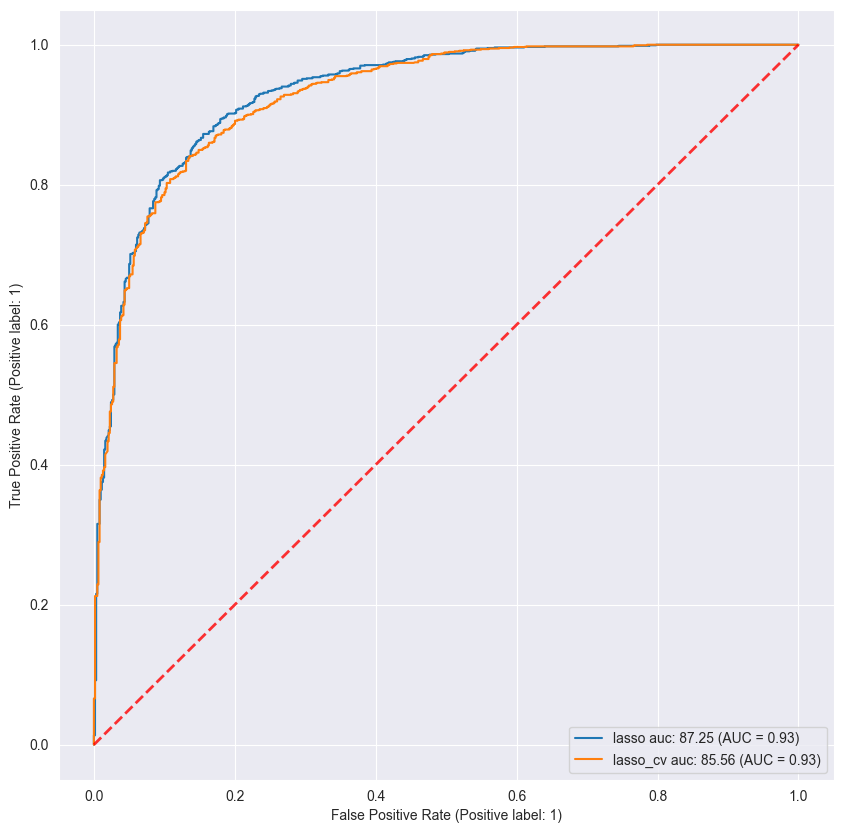

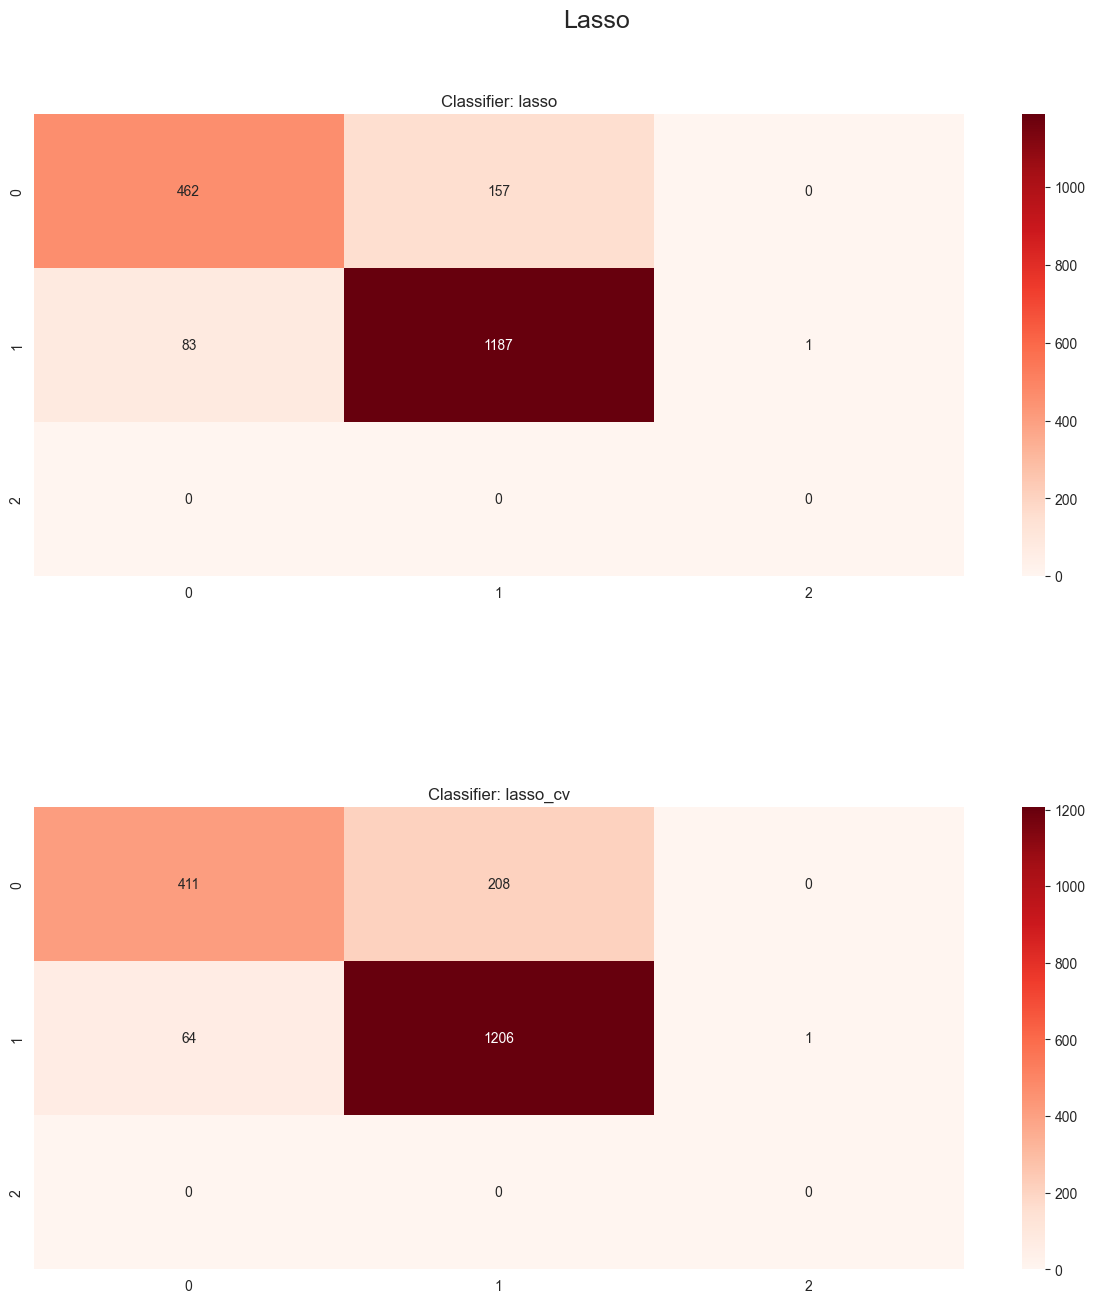

sgd_model
hyper_tuned_sgd_model


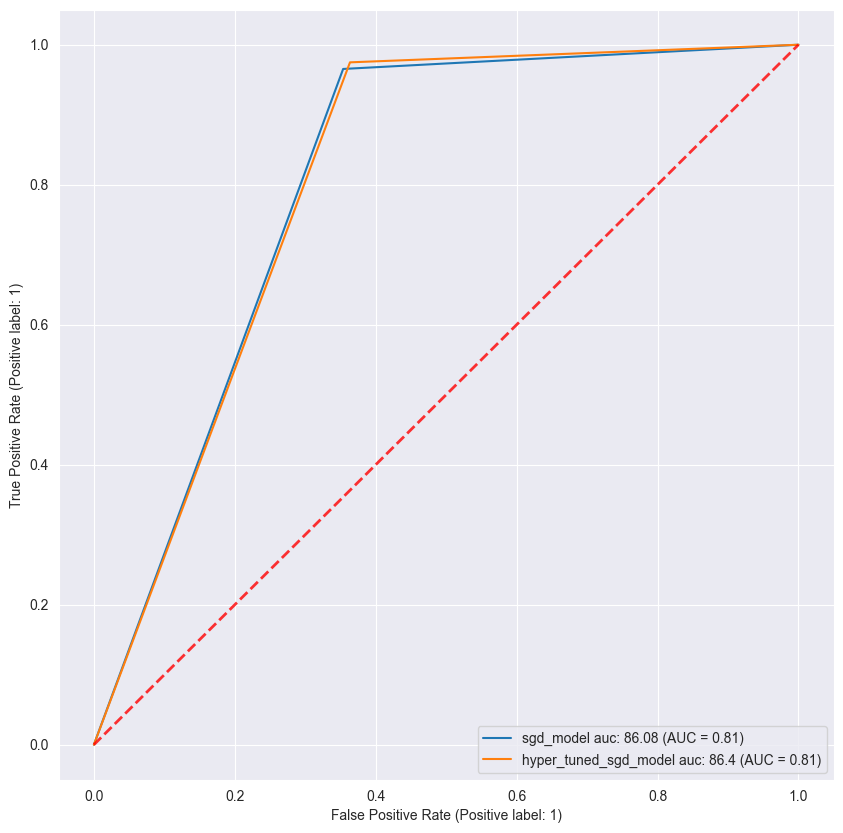

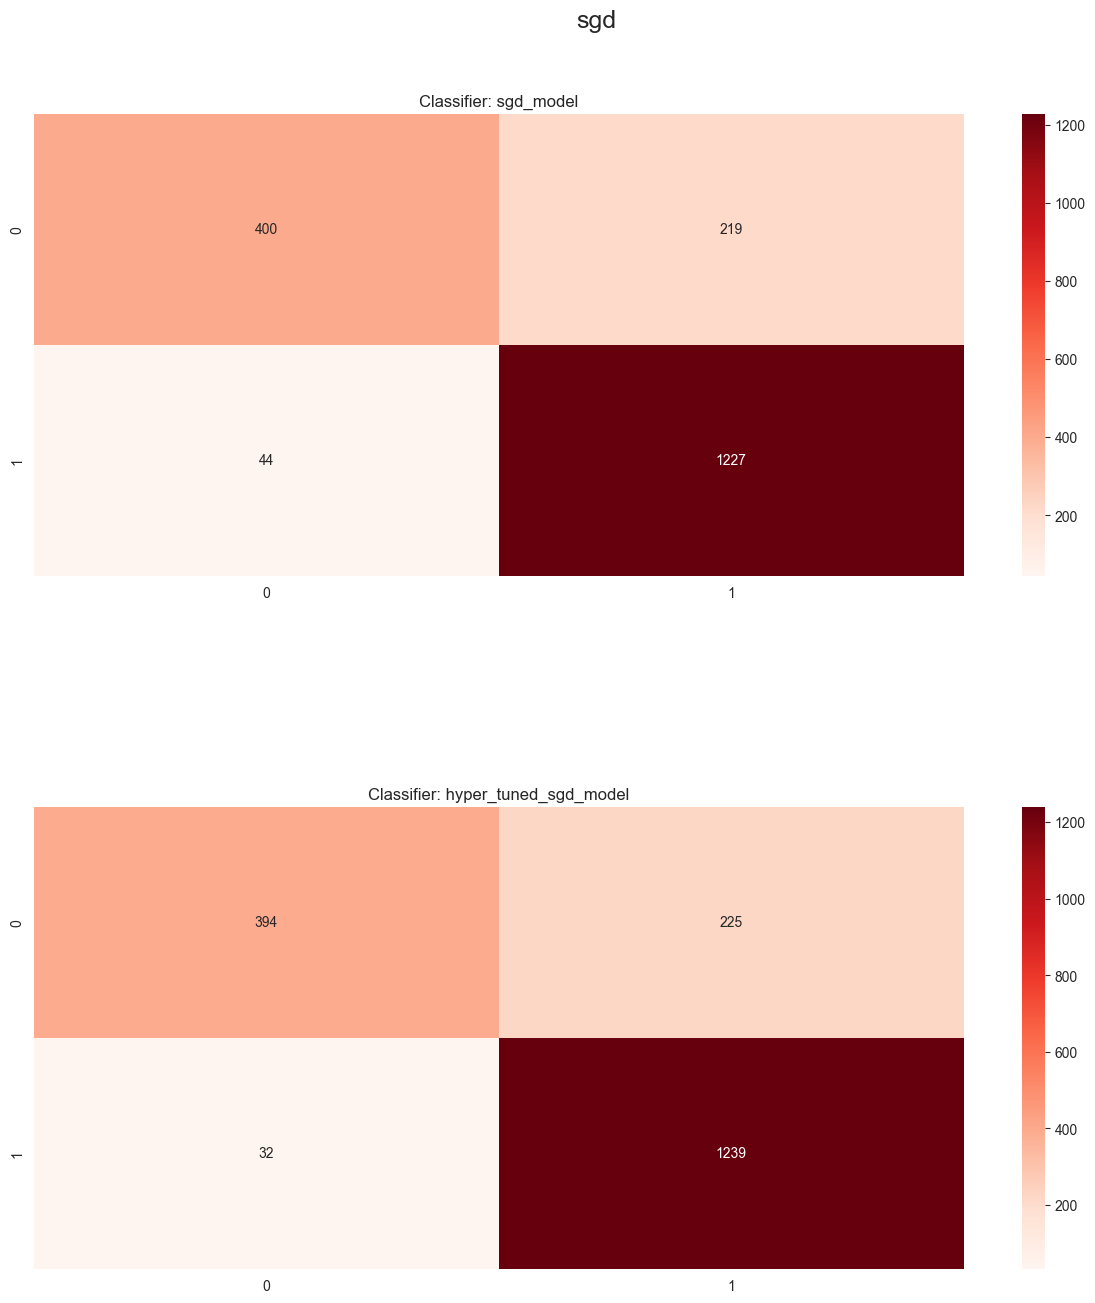

ridge_model
hyper_tuned_ridge_model


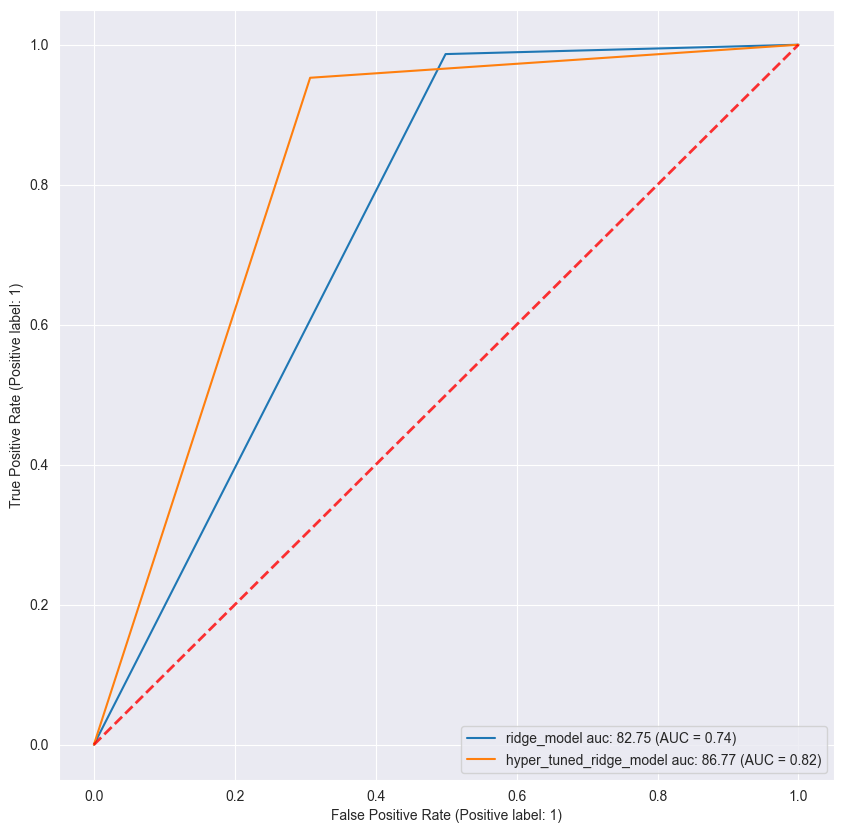

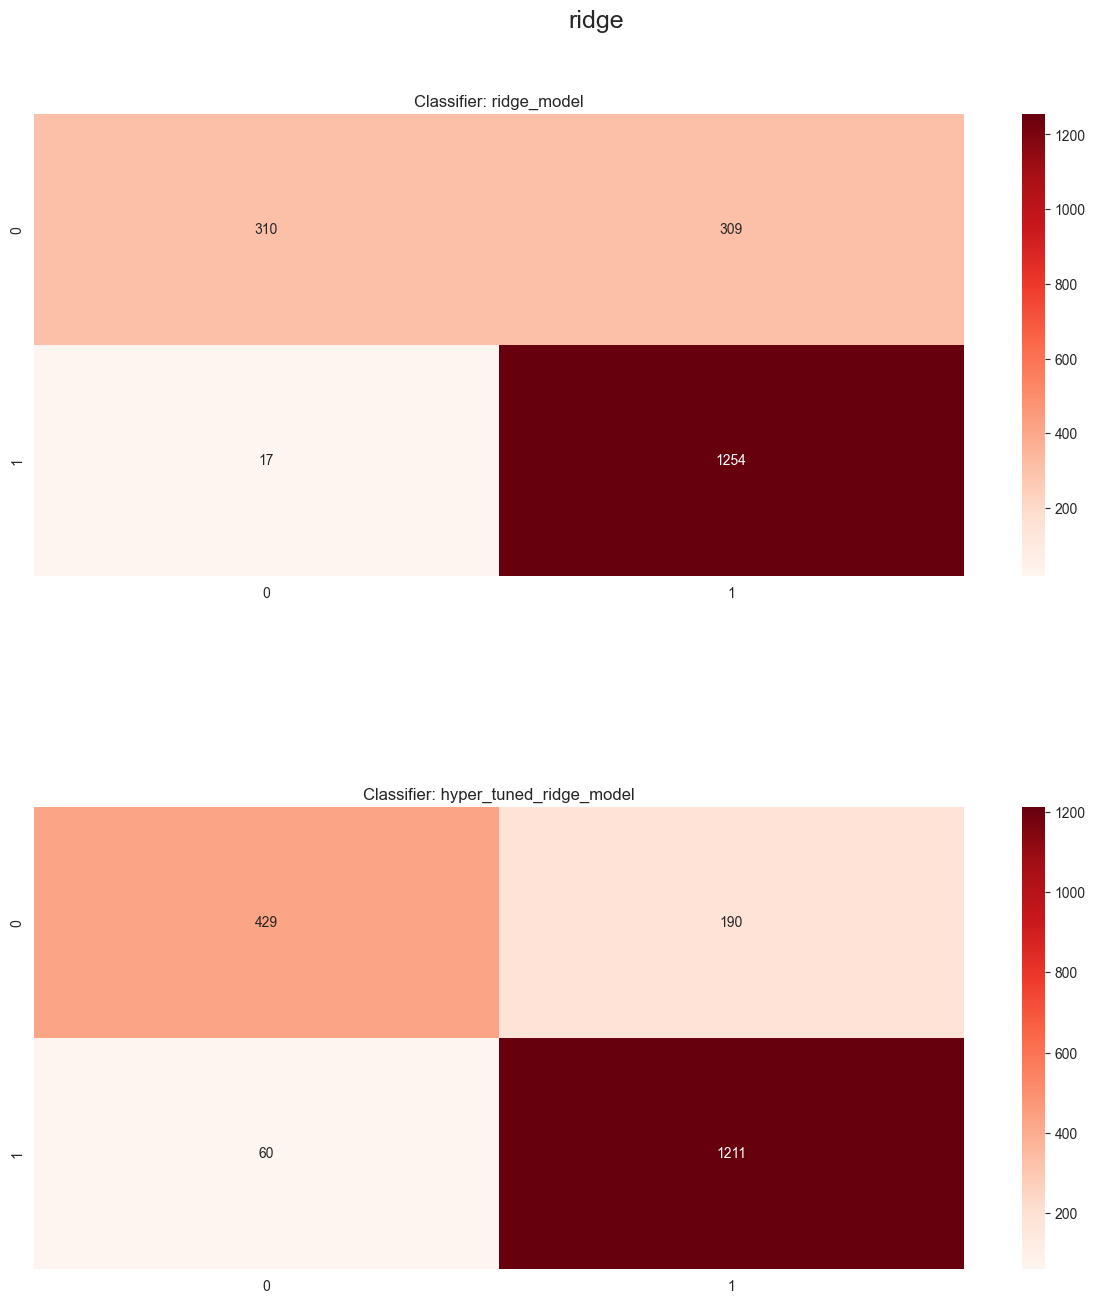

logmodel
hyper_tuned_log_model


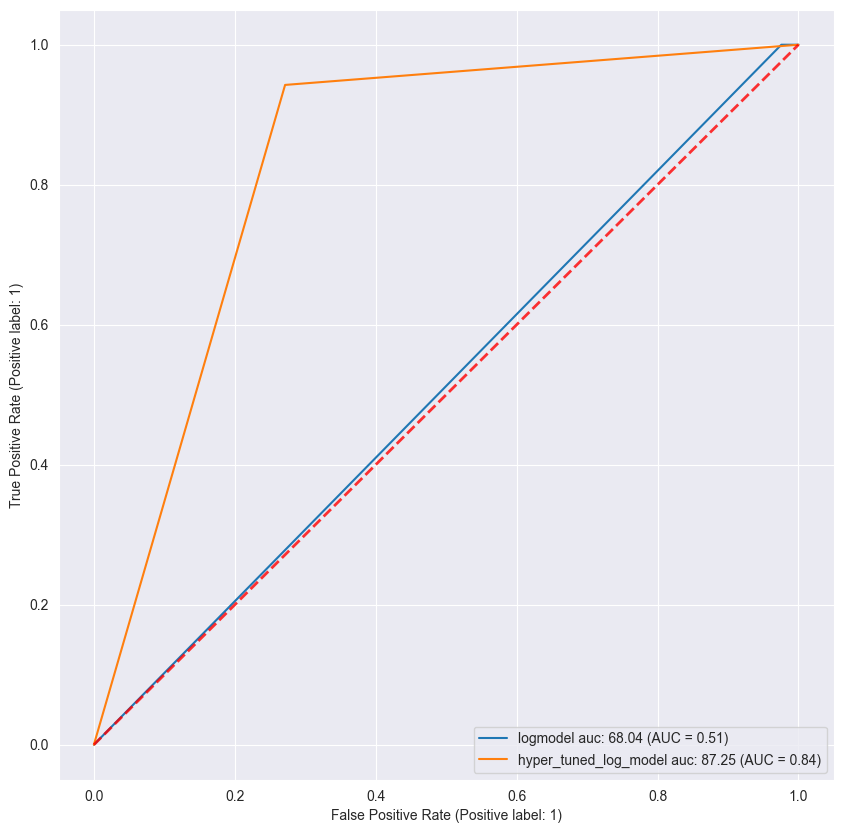

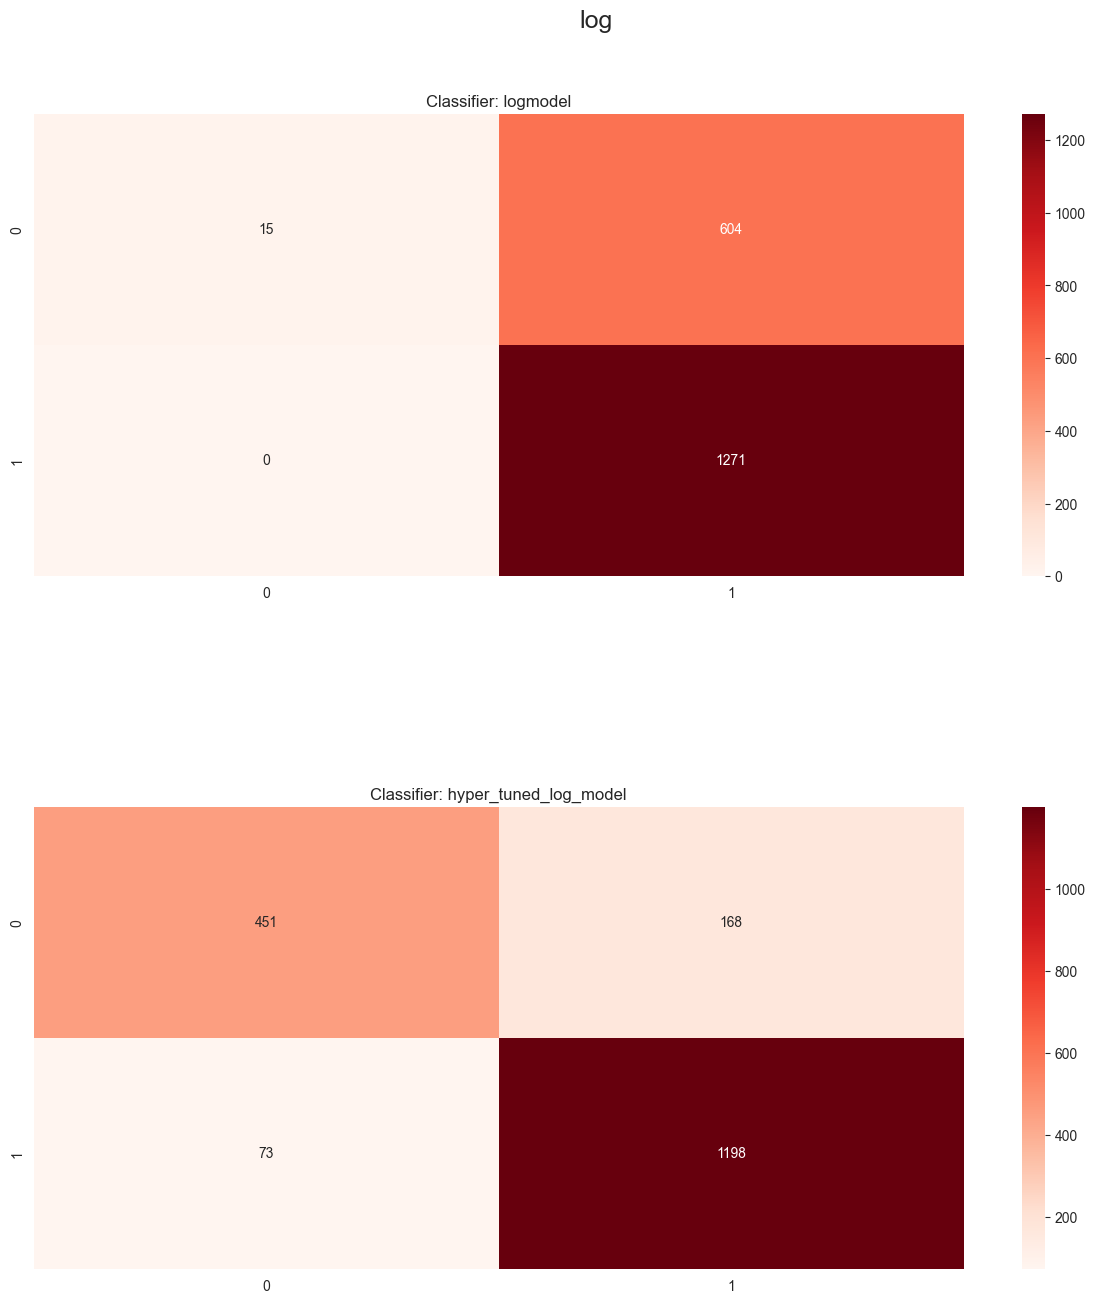

In [204]:
for name,dct in optimizer_dict.items():
    preds = Multiple_prediction(dct["names"], dct["classifier"],X,Y)
    res = preds.run_predictions()

    multiple_preds.roc_plot_from_res(res)
    multiple_preds.matrix_plot_from_res(res,name)

In [ ]:
features, labels, ids = pre_process_data(files["cdk2"])

In [264]:

summary_dict = {}
optimized = True

count = 0

for kinase, path in files.items():
    print(kinase)
    features, labels, ids = pre_process_data(files[kinase])
    normalize_dat = DataNormalize(features)
    similarity = normalize_dat.similarity
    U, sigma, Vt = normalize_dat.svd()
    X = U
    Y = labels
    multiple_preds = Multiple_prediction(names,classifiers, X, Y)
    results = multiple_preds.run_predictions()
    above_res, below_res = multiple_preds.sep_results()
    optimizer = Optimizer(X,Y)

    if not optimized:
        log_model, logistic_params = optimizer.logistic_regression_hyper()
        ridge_model, ridge_params = optimizer.ridge_classifier_hyper()
        sgd_model, sgd_params = optimizer.sgd_classifier_hyper()
        lasso_model, lasso_alpha = optimizer.lasso_hyper()
        optimized = True

    optimizer_res = [log_model, logistic_params,
                ridge_model, ridge_params,
                sgd_model, sgd_params,
                lasso_model, lasso_alpha,]
    optimizer_dict = optimizer_results(optimizer_res)
    optimized_results = run_optimized_preds(optimizer_dict)
    summary_dict[kinase] = {}
    summary_dict[kinase]["Y"] = Y
    summary_dict[kinase]["X"] = X
    summary_dict[kinase]["results"] = results
    summary_dict[kinase]["above_res"] = above_res
    summary_dict[kinase]["below_res"] = below_res
    summary_dict[kinase]["optimized_res"] = optimized_results

    if count > 1:
        break

    count += 1

cdk2
ElasticNet
SVC
kSVC
KNN
DecisionTree
RandomForestClassifier
GridSearchCV
Fitting 5 folds for each of 25 candidates, totalling 125 fits
HuberRegressor
Ridge
Lasso
LassoCV
Lars
LarsCV
BayesianRidge
SGDClassifier
RidgeClassifier
LogisticRegression
OrthogonalMatchingPursuit
lasso
lasso_cv
sgd_model
hyper_tuned_sgd_model
ridge_model
hyper_tuned_ridge_model
logmodel
hyper_tuned_log_model
egfr
ElasticNet
SVC
kSVC
KNN
DecisionTree
RandomForestClassifier
GridSearchCV
Fitting 5 folds for each of 25 candidates, totalling 125 fits
HuberRegressor
Ridge
Lasso
LassoCV
Lars
LarsCV
BayesianRidge
SGDClassifier
RidgeClassifier
LogisticRegression
OrthogonalMatchingPursuit
lasso
lasso_cv
sgd_model
hyper_tuned_sgd_model
ridge_model
hyper_tuned_ridge_model
logmodel
hyper_tuned_log_model
gsk3b
ElasticNet
SVC
kSVC
KNN
DecisionTree
RandomForestClassifier
GridSearchCV
Fitting 5 folds for each of 25 candidates, totalling 125 fits
HuberRegressor
Ridge
Lasso
LassoCV
Lars
LarsCV
BayesianRidge
SGDClassifier
Ridg

In [265]:
def plot_by_kinases(summary_dict,result):
    for kinase, res in summary_dict.items():
        multiple_plt = Multiple_plots(res[result],kinase,res["Y"])
        multiple_plt.roc_plot_from_res()
        multiple_plt.matrix_plot_from_res()

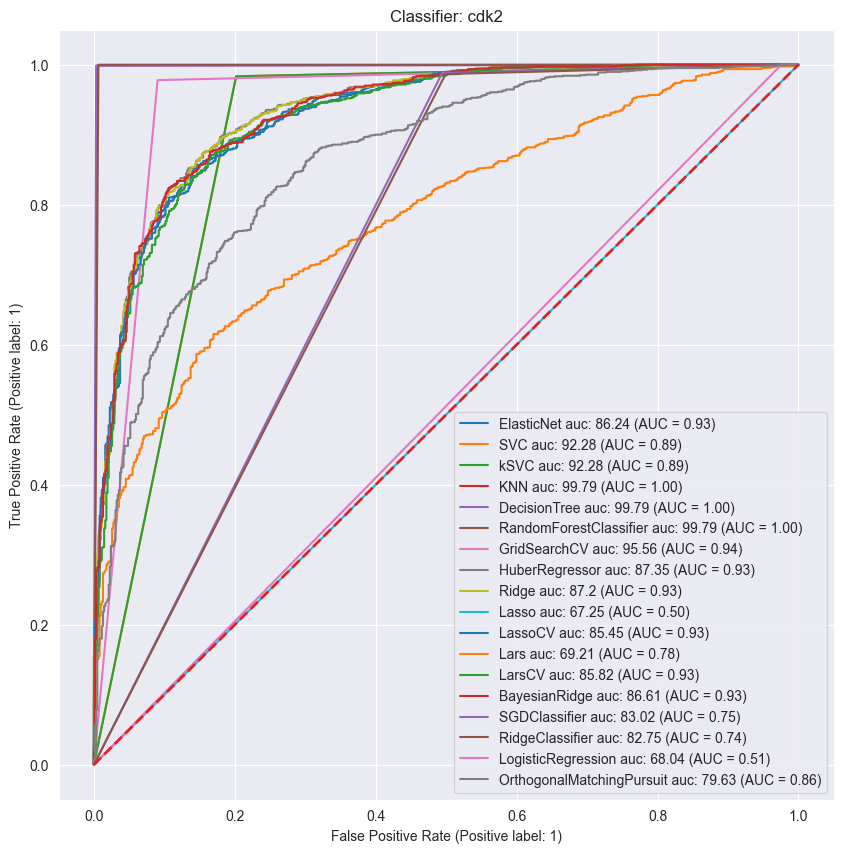

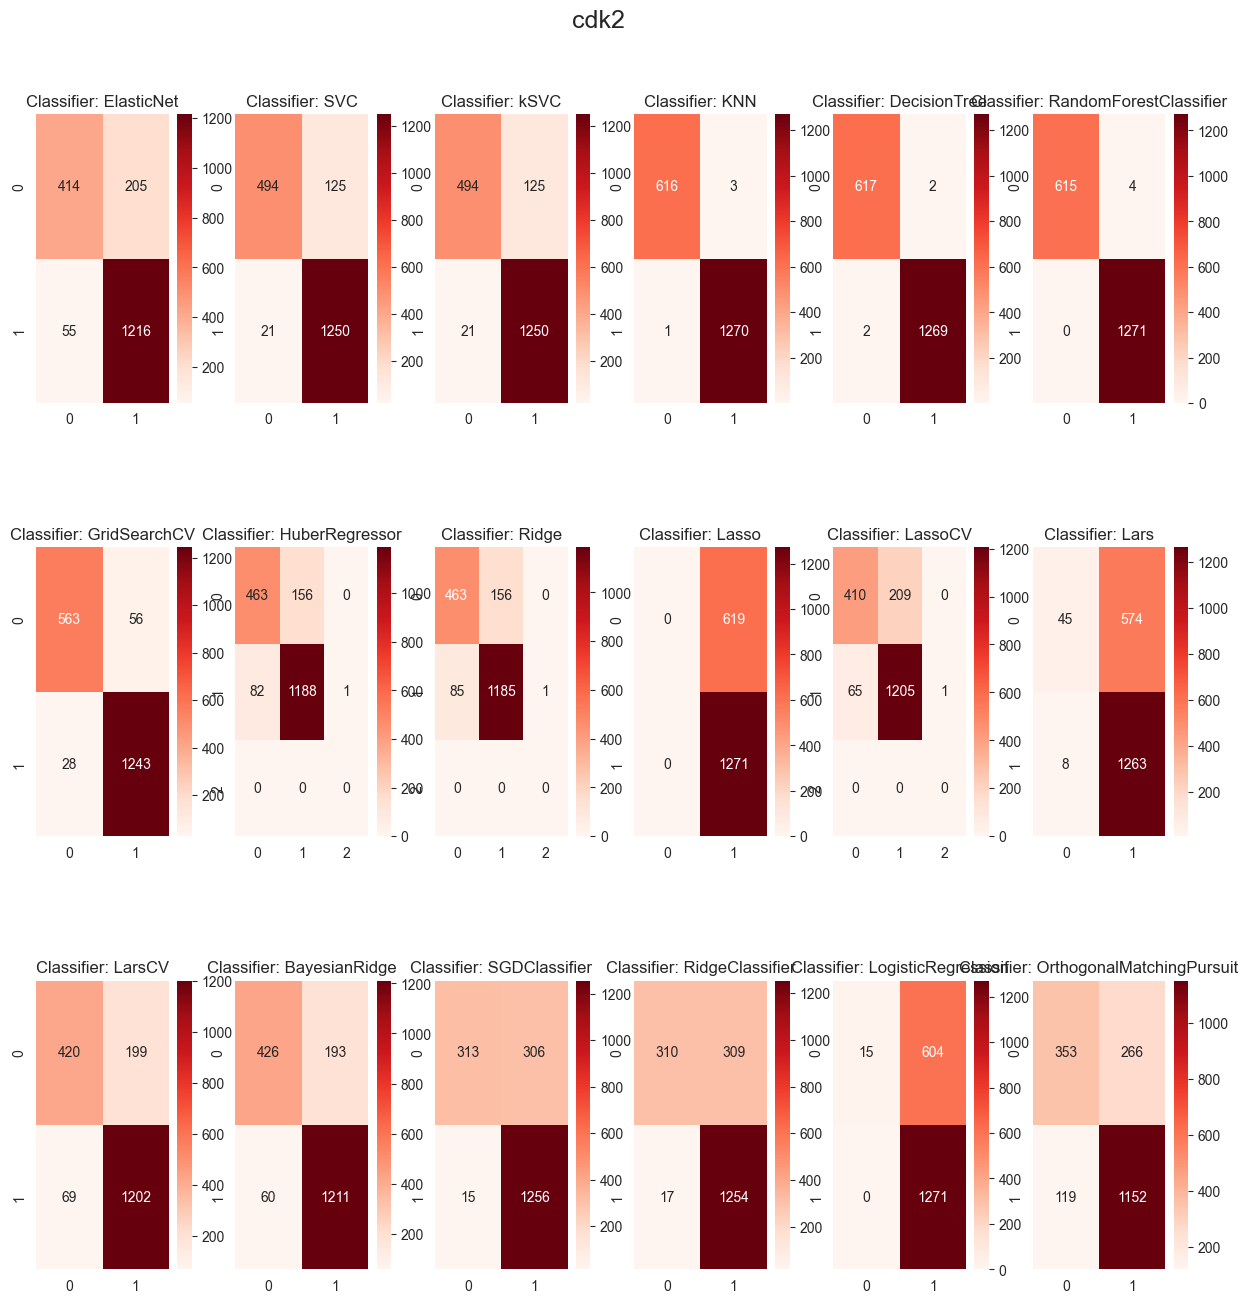

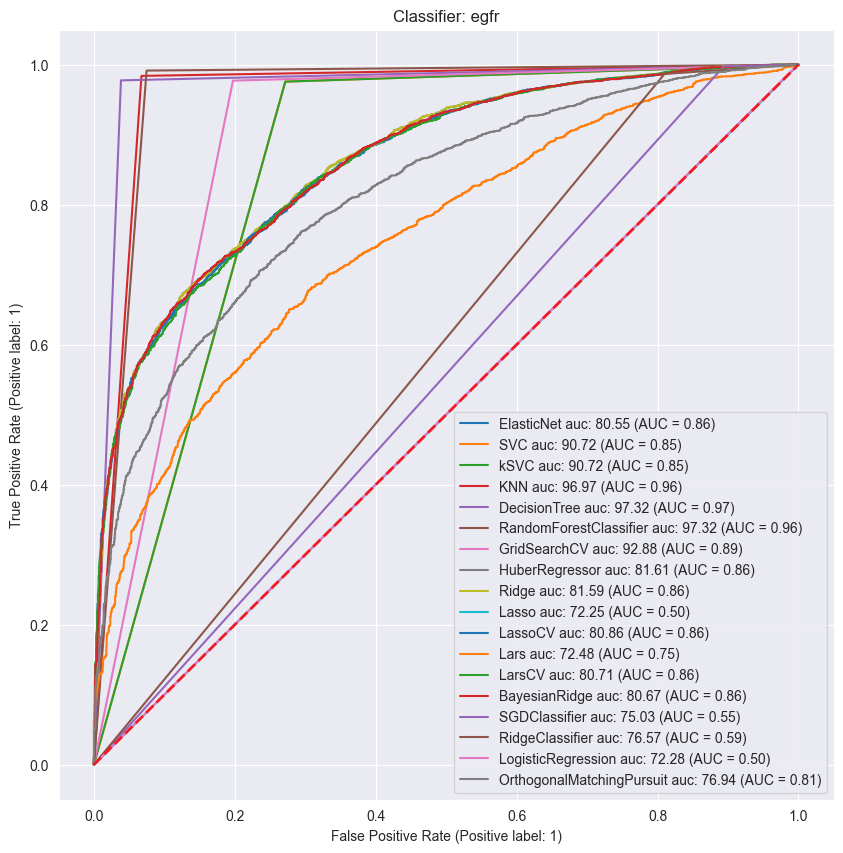

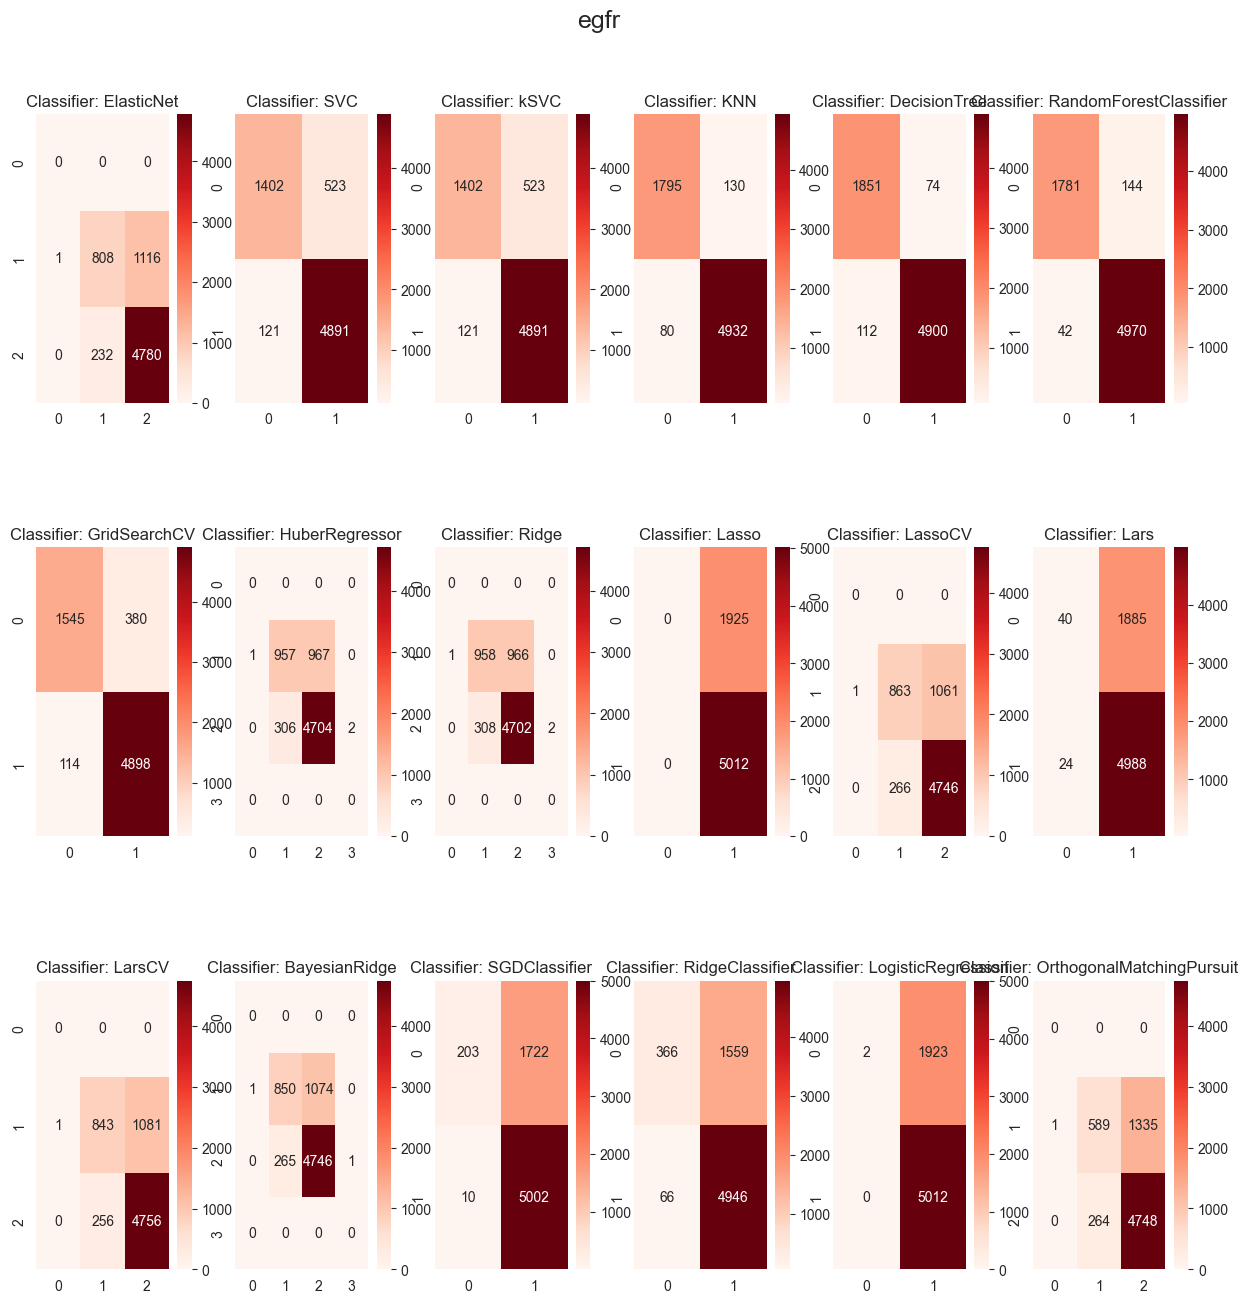

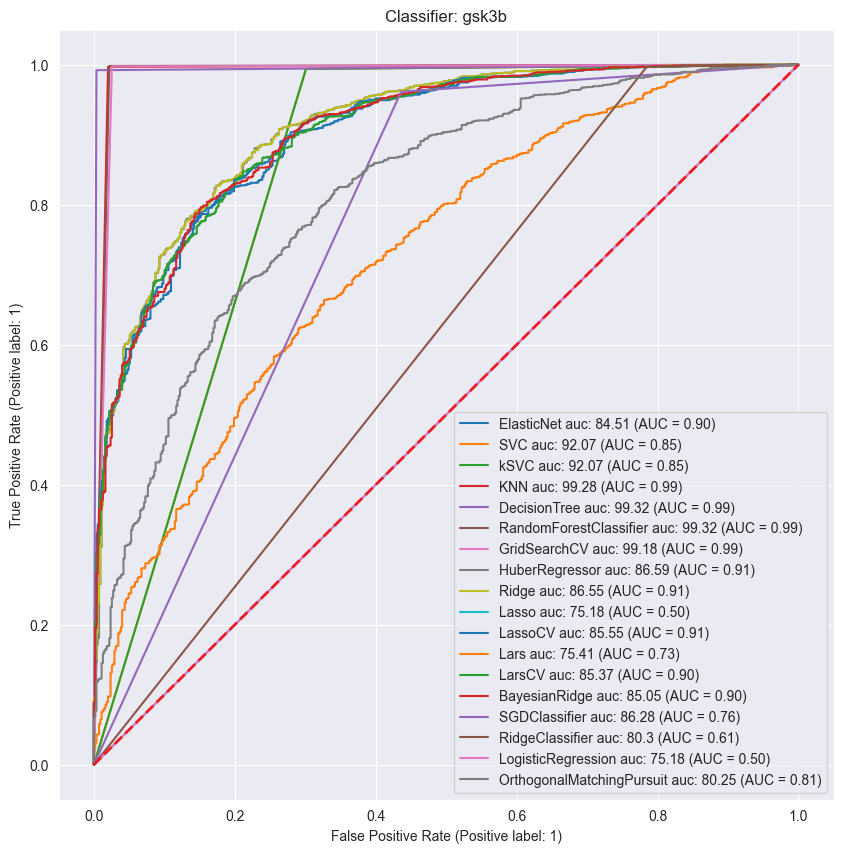

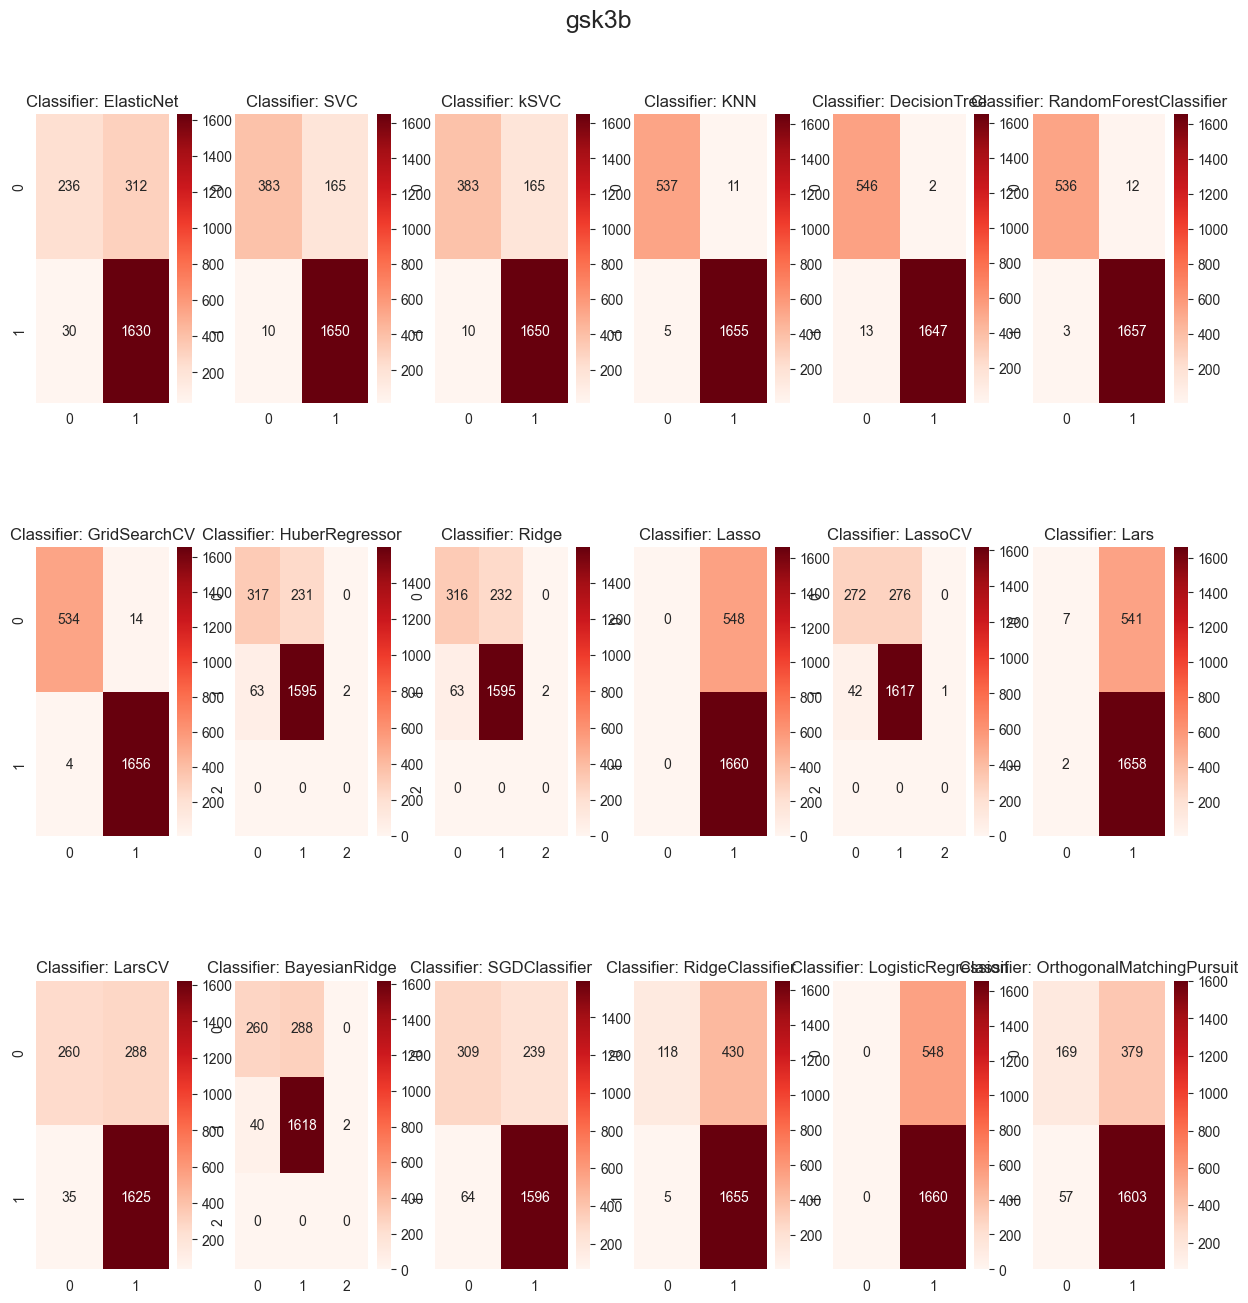

In [266]:
plot_by_kinases(summary_dict,"results")

In [281]:
def plot_by_feature(summary_dict,result,number):
    inner_res = {}
    for kinase, res in summary_dict.items():
        inner_res[kinase] = res[result]
        inner_res["Y"] =res["Y"]

    print(inner_res)
    # for feat, res in inner_res.items():


In [282]:
plot_by_feature(summary_dict,"above_res",0)

{'cdk2': {'SVC': {'report': '              precision    recall  f1-score   support\n\n           0       0.96      0.80      0.87       619\n           1       0.91      0.98      0.94      1271\n\n    accuracy                           0.92      1890\n   macro avg       0.93      0.89      0.91      1890\nweighted avg       0.93      0.92      0.92      1890\n', 'matrix': array([[ 494,  125],
       [  21, 1250]], dtype=int64), 'logreg_accuracy': 92.28, 'y_pred': array([1, 1, 0, ..., 0, 1, 1], dtype=int64)}, 'kSVC': {'report': '              precision    recall  f1-score   support\n\n           0       0.96      0.80      0.87       619\n           1       0.91      0.98      0.94      1271\n\n    accuracy                           0.92      1890\n   macro avg       0.93      0.89      0.91      1890\nweighted avg       0.93      0.92      0.92      1890\n', 'matrix': array([[ 494,  125],
       [  21, 1250]], dtype=int64), 'logreg_accuracy': 92.28, 'y_pred': array([1, 1, 0, ..., 0, 1